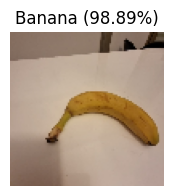

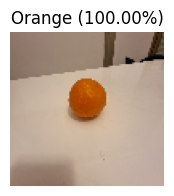

In [7]:
import tensorflow as tf  
from tensorflow.keras.preprocessing import image  
import numpy as np  
import matplotlib.pyplot as plt  
  
# Load the TFLite model and allocate tensors.  
tflite_model_path = 'output/model.tflite'  
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)  
interpreter.allocate_tensors()  
  
# Get input and output tensors.  
input_details = interpreter.get_input_details()  
output_details = interpreter.get_output_details()  
  
# Function to predict and display image for TFLite model  
def predict_and_display_image_tflite(image_path, interpreter):  
    img = image.load_img(image_path, target_size=(96, 96))  
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0) / 255.0  
  
    interpreter.set_tensor(input_details[0]['index'], img_array.astype('float32'))  
    interpreter.invoke()  
  
    prediction_score = interpreter.get_tensor(output_details[0]['index'])[0]  
  
    if prediction_score.ndim == 1:  # Multi-class case  
        class_prediction = np.argmax(prediction_score)  
        score = prediction_score[class_prediction] * 100  
        class_names = ['Banana', 'Orange']  # Assuming class_names are defined in the same order as during model training  
        predicted_class_name = class_names[class_prediction]  
    else:  # Binary case, simplified for demonstration  
        if prediction_score < 0.5:  
            predicted_class_name = 'Banana'  
            score = (1 - prediction_score[0]) * 100  
        else:  
            predicted_class_name = 'Orange'  
            score = prediction_score[0] * 100  
  
    plt.figure(figsize=(2, 2))  
    plt.imshow(img)  
    plt.axis('off')  
    plt.title(f'{predicted_class_name} ({score:.2f}%)')  
    plt.show()  
  
# Example usage  
predict_and_display_image_tflite("test/banana.4piv5bho.ingestion-d59dc547b-j6mhk.jpg", interpreter)  
predict_and_display_image_tflite("test/orange.4piv9lmk.ingestion-d59dc547b-94nn2.jpg", interpreter)  

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  

test_dir = 'dataset/test'
classes = ['oranges', 'bananas']  
batch_size = 32

img_width, img_height = 128, 128  

test_datagen = ImageDataGenerator(rescale=1./255)  
test_generator = test_datagen.flow_from_directory(  
    directory=test_dir,  # Make sure this points to your test dataset directory  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='binary'  # or 'categorical' if you have more than two classes  
)  

# Load the TFLite model  
tflite_model_path = 'output/model.tflite'  
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)  
interpreter.allocate_tensors()  
  
# Get input and output details  
input_details = interpreter.get_input_details()  
output_details = interpreter.get_output_details()  
  
# Function to evaluate accuracy on the test generator  
def evaluate_tflite_model(test_generator, interpreter):  
    total_seen = 0  
    total_correct = 0  
  
    for i in range(len(test_generator)):  
        images, labels = test_generator[i]  # Get the i-th batch  
        for j, image in enumerate(images):  
            # Preprocess the image to fit your TFLite model's input  
            img = np.expand_dims(image, axis=0).astype(input_details[0]['dtype'])  
            interpreter.set_tensor(input_details[0]['index'], img)  
            interpreter.invoke()  
  
            output_data = interpreter.get_tensor(output_details[0]['index'])  
            predicted_label = np.argmax(output_data)  
            true_label = np.argmax(labels[j])  
  
            if predicted_label == true_label:  
                total_correct += 1  
            total_seen += 1  
  
    accuracy = total_correct / total_seen  
    return accuracy  
  
# Evaluate the TFLite model  
tflite_accuracy = evaluate_tflite_model(test_generator, interpreter)  
print(f'Test accuracy with .tflite model: {tflite_accuracy*100:.2f}%')  

Found 20 images belonging to 2 classes.
Test accuracy with .tflite model: 100.00%
